# Dataset analysis

Recognition of car traffic lights based on visual observation using convolutional networks.

### Loading libraries

Configuration of the development environment by loading the appropriate libraries and modules.

In [2]:
import json
import numpy as np                      # Support for linear algebra
import pandas as pd                     # Support for working with data and support for loading data from CSV files
import duplicates                       # Search for duplicate files
from PIL import Image                   # An image class from the PIL library, an alternative to OpenCV
import os                               # Access to operating system functions (including access to the file system)
from matplotlib import pyplot as plt    # Support for drawing graphs

%matplotlib inline

### Declare constants

In [3]:
LABEL_FILE = "Bochum.json"

### Loading data

In [4]:
with open(LABEL_FILE, "r") as fp:
    images = json.load(fp)

files_count = 0
image_paths = []
label_dfs = []

for image in images["images"]:

    image_paths.append(image['image_path'])

    files_count += 1

    #TODO: ([at for at in label_df.loc[:,"attributes"] ])?
    label_dfs.append(pd.DataFrame(image["labels"]))

label_df = pd.concat(label_dfs)
attributes_df = pd.DataFrame([at for at in label_df.loc[:,"attributes"] ])

print("File count: ", files_count)

## Studying the properties of a dataset

Once you have loaded the annotation data, you need to analyze the properties of the information available. Good knowledge of the data set will allow you to make the right decisions when designing the detector and will allow for an in-depth understanding of the problem. Conclusions from the entire process can be found at the end of this chapter.

### 1. Search for missing values

The first step in examining the training set is to search the columns for missing values. In many datasets, it happens that individual values are missing in different columns. For example, in a single-family home information set, the "Garage Size" column may not have a value for some homes. This may mean no garage in this case. This will allow us to determine if additional data preprocessing steps, such as injecting values, will be necessary.

In [6]:
print("Empty values")
display(label_df.isnull().sum())
display(attributes_df.isnull().sum())

Empty values
attributes    0
h             0
track_id      0
unique_id     0
w             0
x             0
y             0
dtype: int64
aspects        0
direction      0
occlusion      0
orientation    0
pictogram      0
reflection     0
relevance      0
state          0
dtype: int64


### 2. Check for duplicate files

The presence of duplicates in datasets should also be investigated. In order to ensure appropriate conditions for the learning process, it is important to ensure that all samples are unique. For this purpose, we will use the external library `Duplicate Finder` available at https://github.com/akcarsten/Duplicate-Finder. This library uses the SHA256 algorithm to compute a unique hash value for each file. The probability of two files colliding is so small that it is negligible in practice.

From the results, repetitions related to the existence of catalogs with sample sequences should be filtered out. The authors of the dataset simply copied individual sequences with their dedicated annotations and placed them in a common directory. The name of these directories starts with the `sample` prefix, which will make it easier to filter them out.

In [7]:
# Downloading a list of all duplicate files with their hashes
all_duplicates = duplicates.list_all_duplicates(LABEL_FILE.replace(".json", ""), ext=".tiff", fastscan=True)

print()
print(f'Number of duplicates = {all_duplicates["hash"].nunique()}')
print("Duplicates:")
print(all_duplicates["file"])

/home/yarwest/Code/mentoring/asia/traffic-light/dtld_parsing/Bochum/Bochum1/2015-04-21_17-30-07/DE_BBBR667_2015-04-21_17-30-08-347587_nativeV2.tiff
Number of duplicates = 0
Duplicates:
Series([], Name: file, dtype: object)


### 3. Study of frame properties

When using convolutional neural networks, make sure that the dimensions of all images fed into the network input are the same. To do this, we will iterate through all the graphics available in the dataset and collect their properties in the Pandas table. We will use the PIL library, which when opening an image file does not immediately load it into memory, which will significantly speed up the whole process. The image parameters that we will pay special attention to are:

- width in pixels

- height in pixels

- graphic file format

- number of channels

In [9]:
img_properties_dict = {"name": [], "width": [], "height": [], "format": [], "mode": []}

for image_path in image_paths:
    img = Image.open(image_path)
    name = os.path.basename(image_path)
    img_properties_dict["name"].append(name)
    img_properties_dict["width"].append(img.width)
    img_properties_dict["height"].append(img.height)
    img_properties_dict["format"].append(img.format)
    img_properties_dict["mode"].append(img.mode)

img_properties = pd.DataFrame(img_properties_dict)

print("Counting unique frame parameters:")
img_properties_groups = img_properties.drop(["name"], axis=1).value_counts()
display(img_properties_groups)

Zliczanie unikalnych parametrów klatek:
width  height  format  mode
2048   1024    TIFF    I;16    539
Name: count, dtype: int64


### 4. State Probability Distribution Study

The next important step is to examine the number of states (color of the traffic light) and their portion of the dataset.

Traffic light states:
['green' 'red' 'yellow' 'red_yellow' 'off' 'unknown']
Probability distribution and class size:


,Count,Frequency
state,,
green,1621,0.558773
red,876,0.301965
off,136,0.046880
yellow,121,0.041710
unknown,78,0.026887
red_yellow,69,0.023785


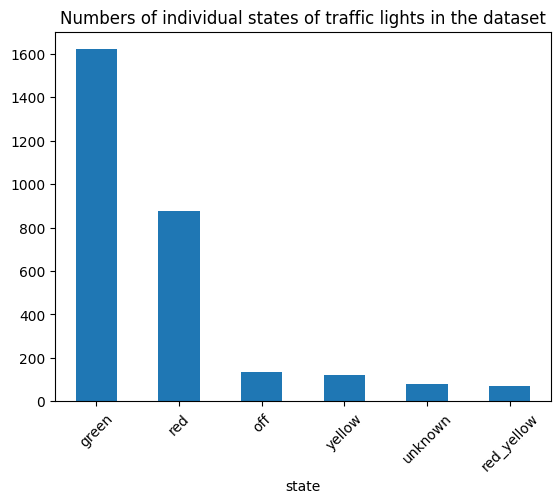

In [10]:
states = attributes_df["state"].unique()
print("Traffic light states:")
print(states)

states_count = attributes_df["state"].value_counts()
states_freq = attributes_df["state"].value_counts(normalize=True)
states_params = pd.DataFrame({"Count": states_count, "Frequency": states_freq})
print("Probability distribution and class size:")
display(states_params)

states_count.plot(
    kind="bar",
    title=f'Numbers of individual states of traffic lights in the dataset',
    rot=45,
)
plt.show()

### Pictogram Probability Distribution Study

The next important step is to examine the number of pictograms and their portion of the dataset.

Traffic light pictograms:
['arrow_left' 'circle' 'pedestrian' 'tram' 'unknown' 'bicycle'
 'arrow_right' 'arrow_straight']
Probability distribution and class size:


,Count,Frequency
pictogram,,
circle,1662,0.572906
arrow_left,416,0.143399
pedestrian,352,0.121337
tram,206,0.071010
unknown,104,0.035850
arrow_right,65,0.022406
arrow_straight,63,0.021717
bicycle,33,0.011375


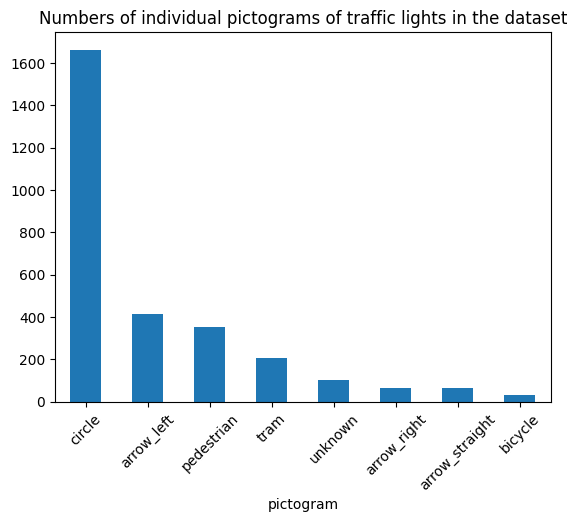

In [12]:
pictogram = attributes_df["pictogram"].unique()
print("Traffic light pictograms:")
print(pictogram)

pictogram_count = attributes_df["pictogram"].value_counts()
pictogram_freq = attributes_df["pictogram"].value_counts(normalize=True)
pictogram_params = pd.DataFrame({"Count": pictogram_count, "Frequency": pictogram_freq})
print("Probability distribution and class size:")
display(pictogram_params)

pictogram_count.plot(
    kind="bar",
    title=f'Numbers of individual pictograms of traffic lights in the dataset',
    rot=45,
)
plt.show()

### Direction Probability Distribution Study

The dataset also contains label data for traffic lights which are seen from behind or the side. These instances might not provide useful references for our model so it would be wise to see how big of a portion of the data set they are.

(TODO??) see how many traffic lights with direction 'back' have state 'off' or 'unknown'

In [ ]:
directions = attributes_df["direction"].unique()
print("Traffic light directions:")
print(directions)

directions_count = attributes_df["direction"].value_counts()
directions_freq = attributes_df["direction"].value_counts(normalize=True)
directions_params = pd.DataFrame({"Count": directions_count, "Frequency": directions_freq})
print("Probability distribution and class size:")
display(directions_params)

directions_count.plot(
    kind="bar",
    title=f'Numbers of individual directions of traffic lights in the dataset',
    rot=45,
)
plt.show()

In [ ]:
### Observations and conclusions

The following list contains all the observations and conclusions based on the results obtained in the other sections of this document:

- The labels in the data set exhibit no instances of missing or empty values, indicating a high level of data completeness. Thus additional data preprocessing operations will not be needed.

- There are 40978 frames in total. This is a very large sample, which has a positive effect on the quality of training the neural network.

- The dataset does not contain duplicate frames, so there is no chance of overrepresentation of individual features of specific images.

- The images within the dataset all share consistent properties. They have dimensions of 2048×1024 pixels & TIFF file format. REMOVE -> ???The size of the graphics is quite large considering the fact that they will be used in the process of teaching the neural network. This will have a negative impact on the time of network training as well as on the consumption of hardware resources (especially the memory of the graphics processor).

- The most prevelant traffic light states (excluding 'unknown') are 'green' and 'red'. There are several times more of them than each of the other classes and in total they constitute over 60% of the data set. This distribution can potentially impact the performance of any model trained on this data set, especially due to the imbalance between green and yellow states.

- The 'unknown' traffic light state makes up 27% of all data points, which could potentially harm the reliability of the model as these traffic lights might not be properly visible or photographed from an angle that obstructs their visibility.

- 'yellow', 'red_yellow' & 'off' have a frequency of less than 10%. Underrepresentation of these classes may prevent us from achieving a sufficiently good precision in detecting them. Despite the large amount of training data, there is a suspicion that the detection efficiency of these signals may not be sufficient for the network to be used in real-life conditions, where almost 100% is required in every case.

- Due to the fact that the data set is based on sequential recordings, and not on random photos, the distribution of states in our dataset reflects real-world traffic light dynamics and provides insight into their usage patterns. For example, a warning light (yellow) is lit much shorter than a red or green light, and this fact is reflected in the shortage of the `yellow` and `red_yellow` states within our data.

- The most prevelant traffic light pictograms (excluding 'unknown') are 'circle' (43%) and 'pedestrian' (20%). This distribution can have a big impact on the performance of any model trained on this data set.

- 'tram', 'arrow_straight', 'bicycle', 'pedestrian_bicycle', 'arrow_right', 'arrow_straight_left' are all less than 5% of the data set, which can lead to dificulties with the recognition of such traffic lights.

(TODO?? see if train & test data seperately have good distribution)
Based on this research, we can make a final decision on how to work with the dataset. The division into train and test subsets can be used as proposed by the authors of the data set.